In [1]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt

from numpy.typing import NDArray
from typing import Any
from typing import Callable

from functools import partial

## Data
The data has 3 columns which we extract into `x`, `y_observed`, `y_error`.

<ErrorbarContainer object of 3 artists>

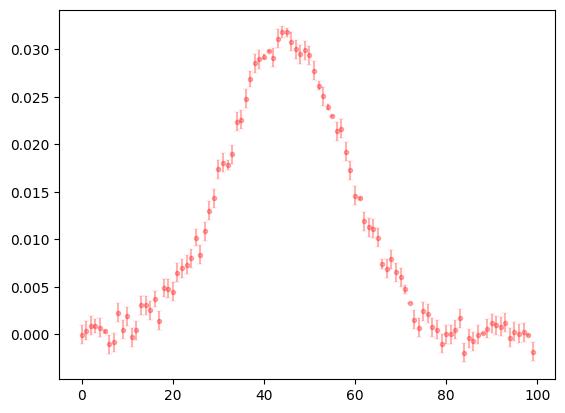

In [2]:
# read in data
x, y_observed, y_error = np.loadtxt("./hw2_fitting.dat").T

# and plot
plt.errorbar(x, y_observed, y_error, fmt=".r", capsize=2, capthick=0.3, alpha=0.3)

# The Levenberg-Marquadt Algorithm
The Levenberg-Maqquadt Algorithm is an algorithm used to solve non-linear least squares problem which one typically encounters when curve fitting a model function to an observed data set. This notebook outlines my own implementation. 

## $\chi^2$ Loss Function
Given a chosen family of function, $f_\beta(\mathbf{x})$ where $\beta$ are parameters to specific functions, we use the $\chi^2$ loss to measure how well our model fits the data. It is given by:
$$
    \chi^2(x; f_\beta) = \sum_{\forall i} \left(\dfrac{f_\beta(x_i) - y_i}{\sigma_i}\right)^2,
$$
representing the sum of the squared deviation. When the obsereved data has uncertainties, we can weigh the deviations with $1/\sigma_i$ such that data points with larger uncertainties are less important. 

We implement a vectorized version of the $\chi^2$ loss here which is simply
$$
    \chi^2(\mathbf{x}; f) = ||(f(\mathbf{x}) - \mathbf{y}) \odot \mathbf{\sigma}^{-1}||^2,
$$
where $\mathbf{\sigma}^{-1}$ is the element-wise reciprocal of $\mathbf{\sigma}$ and $\odot$ represents element-wise multiplication. $||\,.\,||$ is the standard 2-norm.

In [3]:
def chi_squared(y_observed: NDArray[Any], y_error: NDArray[Any], y_model: NDArray[Any]) -> NDArray[Any]:
    weighted_residuals = (y_model - y_observed)/y_error

    # chi-squared is the squared norm of the residuals
    # which on R^N is a simple dot product
    return weighted_residuals.T @ weighted_residuals

In this homework, we will choose the Gaussian and Lorentzian families of function as our model. We utilize calculus to minimize the $\chi^2$ by taking the derivative with respect to the parameters $\beta$...

I won't do a full write up, but you'll want to continue with the exposition in your assignment. Use the report to motivate the code implementation, not the other way around. First and second derivatives, how to construct the LM matrix. You get the idea.

## Gaussian
We define the Gaussian model and its Jacobian here.

In [4]:
# define gaussian model here
def gaussian_model(x: NDArray[Any], parameter: NDArray[Any]) -> NDArray[Any]:
    nu, alpha_d = parameter

    LOG2 = np.log(2)
    SQRT_LOG2_OVER_PI = np.sqrt(np.log(2) / np.pi)

    return (
        1 / alpha_d
        * SQRT_LOG2_OVER_PI
        * np.exp(-LOG2 * (x - nu)**2 / alpha_d**2)
    )

# and we compute the jacobian w.r.t. the parameters
def gaussian_jacobian(x: NDArray[Any], parameter: NDArray[Any]) -> NDArray[Any]:
    nu, alpha_d = parameter

    LOG2 = np.log(2)
    SQRT_LOG2_OVER_PI = np.sqrt(LOG2 / np.pi)

    jacobian = np.zeros((len(x), 2))

    translation = x - nu
    gaussian = np.exp(-LOG2 * translation**2 / alpha_d**2)

    # first derivative wrt to nu
    jacobian[:, 0] = (
        2 / alpha_d**3
        * SQRT_LOG2_OVER_PI * LOG2
        * translation
        * gaussian
    )
    
    # first derivative wrt to alpha_d
    jacobian[:, 1] = (
        1 / alpha_d**4
        * SQRT_LOG2_OVER_PI 
        * (2*LOG2*translation**2 - alpha_d**2)
        * gaussian
    )

    return jacobian

## Lorentzian
And likewise, the Lorentzian and its Jacobian

In [5]:
# define lorentzian model here
def lorentzian_model(x: NDArray[Any], parameter: NDArray[Any]) -> NDArray[Any]:
    nu, alpha_l = parameter
    
    return (
        1 / np.pi
        * alpha_l
        / ((x - nu)**2 + alpha_l**2)
    )

# and we compute the jacobian w.r.t. the parameters
def lorentzian_jacobian(x: NDArray[Any], parameter: NDArray[Any]) -> NDArray[Any]:
    nu, alpha_l = parameter
    
    jacobian = np.zeros((len(x), 2))
    
    translation = x - nu
    
    # first derivative wrt nu
    jacobian[:, 0] = (
        2 / np.pi
        * alpha_l * translation
        / (translation**2 + alpha_l**2)**2
    )

    # first derivative wrt alpha_l
    jacobian[:, 1] = (
        -1 / np.pi
        * (nu + alpha_l - x)
        * (-nu + alpha_l + x)
        / (translation**2 + alpha_l**2)**2
    )

    # reshape the jacobian to be an Nx2 matrix to meet our mathematical needs
    return jacobian

## Algorithm
We split the algorithm into two parts for easier debugging. The logic for computing the $\delta$-steps is separated from the rest of the fitting logic for easier debugging and readability.

In [6]:
def levenberg_marquardt_step(
    residual: NDArray[Any],
    jacobian: NDArray[Any],
    hessian: NDArray[Any],
    *,
    lambda_dampener: float = 1e-3
) -> NDArray[Any]:

    # the algorithm in class is:
    # left_hand_side = hessian + lambda_dampener * np.eye(len(hessian))
    
    # there is a modified algorithm that allows for faster convergence
    # see: https://api.semanticscholar.org/CorpusID:125997188
    left_hand_side = (
        hessian 
        + lambda_dampener * np.diag(np.diag(hessian))
    )
    
    right_hand_side = -jacobian.T @ residual
    
    delta = np.linalg.solve(left_hand_side, right_hand_side)
    
    return delta

To reduce code duplication, we implement the fitting logic so that it is not specific to any chosen model. Instead, the function takes in a `model` and `model_jacobian` as its argument. 

In [7]:
# fitting logic
def levenberg_marquardt_fit(
    x: NDArray[Any], 
    y_observed: NDArray[Any],
    y_error: NDArray[Any],
    model: Callable[[NDArray[Any], NDArray], NDArray[Any]],
    model_jacobian: Callable[[NDArray[Any], NDArray], NDArray[Any]],
    *,
    initial_parameter: NDArray[Any],
    objective_function: Callable[[NDArray[Any], NDArray[Any], NDArray[Any]], NDArray[Any]] = chi_squared,
    lambda_dampener: float = 1,
    lambda_multiplier: float = 10,
    tolerance: float = 1e-6,
    max_iteration: int = 1_000
) -> tuple[NDArray[Any], ...]:
    # keep track of parameters over time
    parameter_history = np.zeros((max_iteration + 1, len(initial_parameter)))
    parameter_history[0, :] = initial_parameter

    # make a partial function of the objective function
    # with y_observed and y_error frozen
    loss_function = partial(objective_function, y_observed, y_error)

    # precompute first step to make the logic in the for loop cleaner
    loss_history = np.zeros(max_iteration + 1)
    loss_history[0] = loss_function(model(x, initial_parameter))

    print("Chi-Squared Value")
    for index in range(1, max_iteration+1):
        parameter = parameter_history[index-1, :]
        loss = loss_history[index-1]

        print(f"Iteration {index}: {loss}")

        # compute these values outside of the LM loop
        # to save computational time
        jacobian = model_jacobian(x, parameter)
        hessian = jacobian.T @ jacobian             # hessian estimation

        # main body of the LM-Algorithm
        while True:            
            # make a step and compute the loss with the new parameters
            delta = levenberg_marquardt_step(
                model(x, parameter) - y_observed,
                jacobian, 
                hessian,
                lambda_dampener=lambda_dampener
            )

            new_parameter = parameter + delta        
            new_loss = loss_function(model(x, new_parameter))

            # sucess! chi-squared is smaller
            # make lambda smaller so we tend towards Gauss-Newton updates
            # and break out of the loop to do some book-keeping
            if new_loss < loss:
                lambda_dampener /= lambda_multiplier
                break

            # Terminate the algorithm as the fit seems to not be making anymore progress
            if lambda_dampener > 1e15:
                print(f"Lambda dampener is very large. Check fit for convergence.")
                return new_parameter, parameter_history, loss_history

            # failed step. chi-squared value is larger
            # make lambda larger so we tend towards using gradient descent updates
            lambda_dampener *= lambda_multiplier

        # we'll record useful information that we will use in 
        # the next step to avoid recalculating
        parameter_history[index] = new_parameter
        loss_history[index] = new_loss
        
        # check if the fit has converged
        if np.abs(new_loss - loss) < tolerance:
            return new_parameter, parameter_history, loss_history

    print("Max iteration reached. Fit might not have converged.")
    return parameter_history[-1], parameter_history, loss_history

We now fit our model to the data, providing it initial parameters. Note that we've estimated the Hessian with $J^\intercal J$ in this routine.

In [8]:
print("Gaussian fit:")
print(20*"-")
gaussian_fit, *_ = levenberg_marquardt_fit(
    x, 
    y_observed, 
    y_error,
    gaussian_model,
    gaussian_jacobian,
    initial_parameter=np.array([40, 10])
)
print(20*"*")
print(f"Estimated parameters are: {gaussian_fit}")

Gaussian fit:
--------------------
Chi-Squared Value
Iteration 1: 148669.71521296664
Iteration 2: 89905.55462817286
Iteration 3: 9757.033682875503
Iteration 4: 131.4700196444692
Iteration 5: 108.07421606350258
Iteration 6: 108.06830125713054
Lambda dampener is very large. Check fit for convergence.
********************
Estimated parameters are: [44.8786818  15.10021952]


In [9]:
print("Lorentzian fit:")
print(20*"-")
lorentz_fit, *_ =  levenberg_marquardt_fit(
    x, 
    y_observed, 
    y_error,
    lorentzian_model,
    lorentzian_jacobian,
    initial_parameter=np.array([40, 10])
)
print(20*"*")
print(f"Estimated parameters are: {lorentz_fit}")

Lorentzian fit:
--------------------
Chi-Squared Value
Iteration 1: 26497.854108439136
Iteration 2: 19931.620790059103
Iteration 3: 15564.669161744148
Iteration 4: 14722.219881916979
Lambda dampener is very large. Check fit for convergence.
********************
Estimated parameters are: [44.59723743  9.76809781]


Text(0, 0.5, 'y')

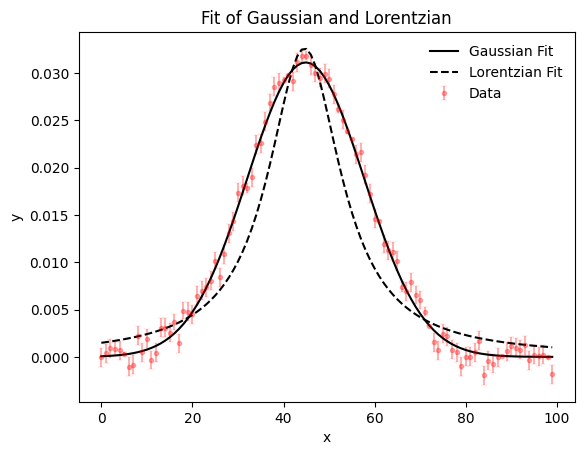

In [10]:
plt.errorbar(x, y_observed, y_error, fmt="r.", label="Data", capsize=2, capthick=0.3, alpha=0.3)
plt.plot(x, gaussian_model(x, gaussian_fit), "k-", label=f"Gaussian Fit")
plt.plot(x, lorentzian_model(x, lorentz_fit), "k--", label=f"Lorentzian Fit")
plt.legend(frameon=False)

plt.title("Fit of Gaussian and Lorentzian")
plt.xlabel("x")
plt.ylabel("y")

## Results
The table below summarizes the results of the fit.
|  | Gaussian | Lorentzian |
| --- | --- | --- |
| Estimated $\nu_0$ | 44.9 | 44.6 |
| Estimated $\alpha$ | 15.1 | 9.8 |
| $\chi^2$ value | 108 | 14722 |

The $\chi^2$ value of the fit with the Gaussian is 2 orders of magnitude lower than the Lorentzian giving us confidence that it is the better fitting model to the data.